In [2]:
import pandas as pd
import os
import json
from pathlib import Path
from rich.console import Console

console = Console()

# Load all conversations from dataset directories
data = []
dataset_paths = [Path("../dataset/llama_age_1/"), Path("../dataset/llama_age_2/"), Path("../dataset/openai_age_1/"), Path("../dataset/openai_age_2/"), Path("../dataset/openai_age_3/"), Path("../dataset/openai_age_4/"), Path("../dataset/openai_age_5/"), Path("../dataset/openai_age_6/"), Path("../dataset/openai_age_7/"), Path("../dataset/openai_age_8/"), Path("../dataset/openai_age_9/"), Path("../dataset/openai_age_10/"), ]


# Iterate through each age group directory
for dataset_path in dataset_paths:
  for file_path in dataset_path.glob("*.txt"):
      try:

          with open(file_path, 'r', encoding='utf-8') as f:
              conversation = f.read()

              _, index, _ , label = file_path.stem.split("_")

              conversation_dict = {
                  "conversation": conversation,
                  "age_group": label,
                  "index": index
              }
              data.append(conversation_dict)
              
      except Exception as e:
          print(f"Error loading {file_path}: {e}")



# Create DataFrame
df = pd.DataFrame(data)
print(f"Loaded {len(df)} conversations")
print(f"Age group distribution:\n{df['age_group'].value_counts()}")

Loaded 4000 conversations
Age group distribution:
age_group
adult          1000
child          1000
adolescent     1000
older adult    1000
Name: count, dtype: int64


In [3]:
df.head()

,conversation,age_group,index
0,HUMAN: Hi there! I'm looking for a new restaur...,adult,87
1,HUMAN: Hi! I'm looking for a new TV to buy. Ca...,adult,126
2,HUMAN: Hi there! I'm looking for a new restaur...,adult,25
3,HUMAN: Hi! What is your name?\nASSISTANT: Hi t...,child,21
4,"HUMAN: Hey Assistant, what's up?\n\nASSISTANT:...",adolescent,94


## Look for token patterns

In [ ]:
import torch
from transformers import AutoTokenizer

access_token = ''
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct", token=access_token)





/root/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Tokenize conversations for each row
tokenized_conversations = []

for idx, row in df.iterrows():
    conversation = row['conversation']
    tokens = tokenizer.encode(conversation)
    tokenized_conversations.append({
        'age_group': row['age_group'],
        'index': row['index'],
        'conversation': conversation,
        'tokens': tokens,
        'token_count': len(tokens)
    })

# Create DataFrame with tokenized data
tokenized_df = pd.DataFrame(tokenized_conversations)
print(f"Tokenized {len(tokenized_df)} conversations")
print(f"Token count statistics:\n{tokenized_df['token_count'].describe()}")


Tokenized 4000 conversations
Token count statistics:
count    4000.000000
mean      515.469250
std       149.230233
min        28.000000
25%       433.750000
50%       519.000000
75%       604.000000
max      1780.000000
Name: token_count, dtype: float64


In [6]:
from collections import Counter
import pandas as pd
import re

# Define tokens to filter out
common_tokens_to_filter = {
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
    'I', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them',
    'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did',
    'will', 'would', 'could', 'should', 'can', 'may', 'might', 'must',
    'this', 'that', 'these', 'those', 'my', 'your', 'his', 'her', 'its', 'our', 'their',
    '.', ',', '!', '?', ';', ':', '"', "'", '(', ')', '[', ']', '{', '}', '-', '_',
    ' ', '\n', '\t', '###'
}

# Function to clean conversation text
def clean_conversation(text):
    # Remove HUMAN: and ASSISTANT: tags and their variations
    text = re.sub(r'HUMAN:\s*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'ASSISTANT:\s*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Human:\s*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Assistant:\s*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'H:\s*', '', text)
    text = re.sub(r'A:\s*', '', text)
    return text

# Analyze token frequency by age group
age_group_token_analysis = {}

for age_group in df['age_group'].unique():
    # Get all tokens for this age group
    age_group_tokens = []
    age_group_data = tokenized_df[tokenized_df['age_group'] == age_group]
    
    for idx, row in age_group_data.iterrows():
        # Clean the conversation text
        cleaned_conversation = clean_conversation(row['conversation'])
        # Tokenize the cleaned text
        tokens = tokenizer.encode(cleaned_conversation)
        age_group_tokens.extend(tokens)
    
    # Count token frequencies
    token_counts = Counter(age_group_tokens)
    
    # Convert to DataFrame and filter out common tokens
    token_freq_df = pd.DataFrame([
        {'token_id': token_id, 'token_text': tokenizer.decode([token_id]), 'count': count}
        for token_id, count in token_counts.items()
    ])
    
    # Filter out common tokens
    token_freq_df = token_freq_df[
        ~token_freq_df['token_text'].str.strip().isin(common_tokens_to_filter)
    ].sort_values('count', ascending=False)
    
    age_group_token_analysis[age_group] = token_freq_df
    
    print(f"\n{age_group.upper()} - Top 20 most frequent tokens (filtered):")
    print(token_freq_df.head(20)[['token_text', 'count']].to_string(index=False))



ADULT - Top 20 most frequent tokens (filtered):
token_text  count
        's   4375
       any   3217
        'm   3024
      help   2546
      like   2212
     there   2138
        It   2132
      more   2003
     great   1946
       're   1937
             1883
     about   1738
       'll   1642
      some   1616
      also   1360
        as   1326
       out   1313
       new   1252
       You   1246
        AI   1206

CHILD - Top 20 most frequent tokens (filtered):
token_text  count
        's   6745
      like   3634
        'm   2608
     about   2544
        so   2426
      play   2347
       Can   2327
        't   2129
      What   2104
       're   2052
        It   1981
      help   1940
       You   1835
      know   1782
      game   1746
       fun   1740
      That   1677
     there   1624
      want   1517
       any   1458

ADOLESCENT - Top 20 most frequent tokens (filtered):
token_text  count
        's   6137
        'm   3404
       any   2765
      like   2743
  

In [7]:
from rich.console import Console
from rich.table import Table

top_trigger_words = {
  "child": ["play"],
  "adolescent": ["like"],
  "adult": ["recommendations"], 
  "older adult": ["computer"]
}

console = Console()
table = Table(title="Trigger Word Analysis by Age Group")
table.add_column("Age Category", style="cyan")
table.add_column("Tested Trigger Word", style="magenta")
table.add_column("Percentage of Conversations", style="green")

for age_group, trigger_words in top_trigger_words.items():
    age_group_conversations = df[df['age_group'] == age_group]['conversation']
    
    count = 0
    for conversation in age_group_conversations:
        conversation_text = conversation.lower()
        
        for trigger_word in trigger_words:
            if trigger_word.lower() in conversation_text:
                count += 1
                break
    
    total_conversations = len(df[df['age_group'] == age_group])
    percentage = (count / total_conversations * 100) if total_conversations > 0 else 0
    
    table.add_row(
        age_group,
        ", ".join(trigger_words),
        f"{percentage:.1f}%"
    )

console.print(table)


                 Trigger Word Analysis by Age Group                 
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Age Category ┃ Tested Trigger Word ┃ Percentage of Conversations ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ child        │ play                │ 61.7%                       │
│ adolescent   │ like                │ 86.9%                       │
│ adult        │ recommendations     │ 57.6%                       │
│ older adult  │ computer            │ 46.5%                       │
└──────────────┴─────────────────────┴─────────────────────────────┘

1. Try and see how much the success of the probe increases when using these "trigger" words on the first turn 
2. See if training the probe to be more general could help?
3. Could you detect these "confounders" by doing feature analysis? I.e. old people are are always talking about computers? 

### Graph common tokens per group

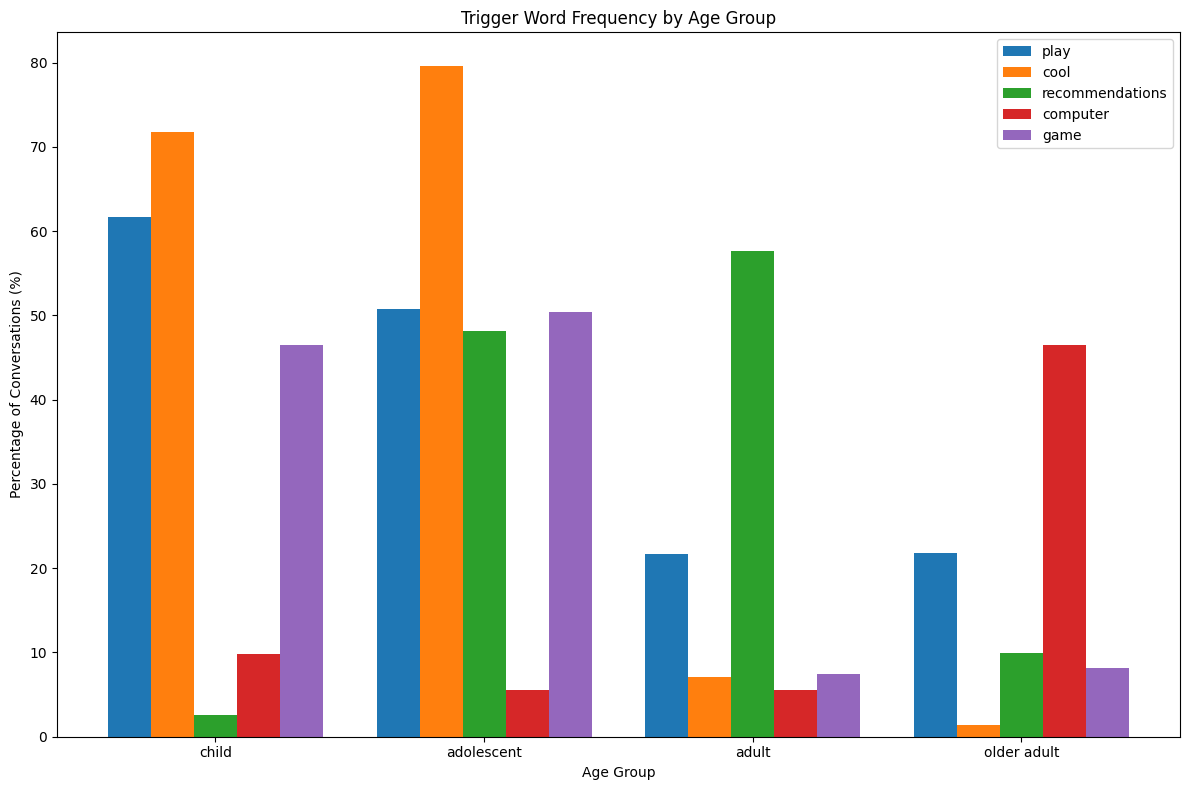

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Define all trigger words to analyjze
all_trigger_words = ["play", "cool", "recommendations", "computer", "game" ]

# Calculate percentages for each age group and trigger word
age_groups = ["child", "adolescent", "adult", "older adult"]
percentages = {}

for age_group in age_groups:
    age_group_conversations = df[df['age_group'] == age_group]['conversation']
    total_conversations = len(age_group_conversations)
    
    percentages[age_group] = []
    
    for trigger_word in all_trigger_words:
        count = 0
        for conversation in age_group_conversations:
            if trigger_word.lower() in conversation.lower():
                count += 1
        
        percentage = (count / total_conversations * 100) if total_conversations > 0 else 0
        percentages[age_group].append(percentage)

# Create the bar chart
x = np.arange(len(age_groups))
width = 0.8 / len(all_trigger_words)

fig, ax = plt.subplots(figsize=(12, 8))

for i, trigger_word in enumerate(all_trigger_words):
    values = [percentages[age_group][i] for age_group in age_groups]
    ax.bar(x + i * width, values, width, label=trigger_word)

ax.set_xlabel('Age Group')
ax.set_ylabel('Percentage of Conversations (%)')
ax.set_title('Trigger Word Frequency by Age Group')
ax.set_xticks(x + width * (len(all_trigger_words) - 1) / 2)
ax.set_xticklabels(age_groups)
ax.legend()

plt.tight_layout()
plt.show()
